# Prediction of Stock Prices using DNN

## Imports

In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import math
import statistics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.1


## Collect the data

In [2]:
input_window_size = 10  # this is the no. of input nodes of the NN
start_date = '2010-01-01'
end_date = '2014-12-31'
dates = pd.date_range(start_date, end_date)

In [3]:
filter_dates = pd.DataFrame(index=dates)
df = pd.read_csv('data/SPY.csv', index_col='Date', parse_dates=True,
                    usecols=['Date', 'Adj Close'], na_values=['nan'])
df = filter_dates.join(df)
df.head()

,Adj Close
2010-01-01,NaN
2010-01-02,NaN
2010-01-03,NaN
2010-01-04,95.097603
2010-01-05,95.349350


## Feature Engineering

In [4]:
df.isna().sum()

Adj Close    568
dtype: int64

In [5]:
df = df.dropna()
df.isna().sum()

Adj Close    0
dtype: int64

In [6]:
df.shape

(1258, 1)

## Normalize the data

In [7]:
# Normalization and Denormalization constants
denorm_const = df['Adj Close'].iloc[0]
norm_const = 1/denorm_const

denorm_const, norm_const

(95.097603, 0.010515512152288423)

In [8]:
# Normalize
df = df*norm_const
df.head()

,Adj Close
2010-01-04,1.000000
2010-01-05,1.002647
2010-01-06,1.003353
2010-01-07,1.007589
2010-01-08,1.010942


## Bollinger Bands

In [9]:
def get_rolling_mean(df_, window):
    return df_.rolling(window).mean()

def get_rolling_std(df_, window):
    return df_.rolling(window).std()

def get_bollinger_bands(rm, rstd):
    upper_band = rm + 2*rstd
    lower_band = rm - 2*rstd
    return upper_band, lower_band

def clip_to_bollinger_bands(df_, window):
    rm = get_rolling_mean(df_, window=window)
    rstd = get_rolling_std(df_, window=window)
    upper_band, lower_band = get_bollinger_bands(rm, rstd)
    return df_.clip(upper=upper_band, lower=lower_band)

In [10]:
def plot_df(df, title="Default Title"):
    ax = df.plot()
    ax.set_xlabel(title)
    ax.get_legend().remove()
    plt.show()

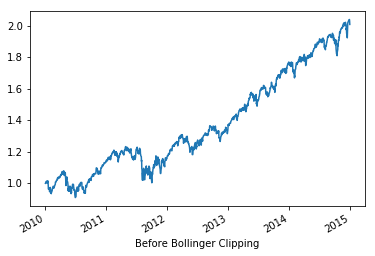

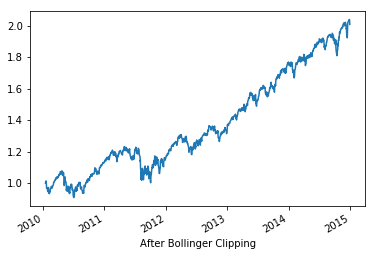

In [11]:
plot_df(df, "Before Bollinger Clipping")
df = clip_to_bollinger_bands(df, input_window_size)
plot_df(df, "After Bollinger Clipping")

After Bollinger Clipping we have first (input_window_size - 1) elements as NaN

In [12]:
df.head(15)

,Adj Close
2010-01-04,NaN
2010-01-05,NaN
2010-01-06,NaN
2010-01-07,NaN
2010-01-08,NaN
2010-01-11,NaN
2010-01-12,NaN
2010-01-13,NaN
2010-01-14,NaN
2010-01-15,1.002736


In [13]:
df.isna().sum()

Adj Close    9
dtype: int64

In [14]:
df = df.dropna()
print(df.isna().sum())
print(df.shape)

Adj Close    0
dtype: int64
(1249, 1)


In [15]:
data = list(df['Adj Close'])
len(data)

1249

## Train, Validation and Test data

### For DNN

Train+Validation : Test = 80 : 20

In [16]:
train_till = int(0.8*len(data))  # this is train + validation

train_raw_data = data[:train_till]
test_raw_data = data[train_till:]

train_features = [train_raw_data[i:i+input_window_size] for i in range(len(train_raw_data)-input_window_size)]
test_features = [test_raw_data[i:i+input_window_size] for i in range(len(test_raw_data)-input_window_size)]

train_labels = train_raw_data[input_window_size:]
test_labels = test_raw_data[input_window_size:]

print(len(train_features), len(train_labels))
print(len(test_features), len(test_labels))

989 989
240 240


In [17]:
train_features = pd.DataFrame.from_records(train_features)
test_features = pd.DataFrame.from_records(test_features)

train_labels = pd.DataFrame(train_labels)
test_labels = pd.DataFrame(test_labels)

print(train_features.shape, train_labels.shape)
print(test_features.shape, test_labels.shape)

(989, 10) (989, 1)
(240, 10) (240, 1)


## Build the model

In [18]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(10, activation=tf.nn.relu, input_shape=[input_window_size]),
        keras.layers.Dense(5, activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [19]:
model = build_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________


## Train the model

### Without Early Stopping

In [20]:
n_epochs = 500
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 50 == 0: print()
        print('.', end='')

history = model.fit(train_features, train_labels, epochs=n_epochs, validation_split=0.2,
                    verbose=0, callbacks=[PrintDot()])

Instructions for updating:
Use tf.cast instead.

..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................

In [21]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
495,0.000200,0.000177,495
496,0.000231,0.000199,496
497,0.000209,0.000157,497
498,0.000205,0.000189,498
499,0.000214,0.000262,499


In [22]:
hist.head()

,loss,val_loss,epoch
0,0.065903,0.001647,0
1,0.002300,0.000575,1
2,0.000798,0.001773,2
3,0.000704,0.001113,3
4,0.000682,0.001268,4


In [23]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    # plt.ylabel('Loss  x($10^{-6}$)')
    plt.ylabel('Loss')
    # plt.plot(hist['epoch'], hist['loss']*1000000, label='Train Loss')
    # plt.plot(hist['epoch'], hist['val_loss']*1000000, label='Validation Loss')
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='Validation Loss')
    # plt.ylim([0, 500])
    plt.legend()

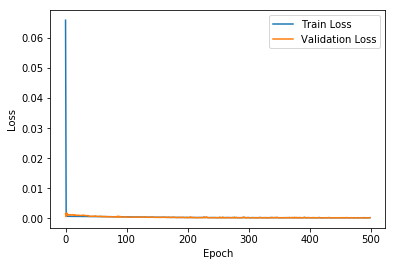

In [24]:
plot_history(history)

### With Early Stopping


..................................................
..

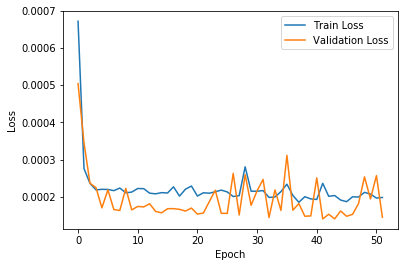

In [25]:
model = build_model()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(train_features, train_labels, epochs=n_epochs, validation_split=0.2,
                    verbose=0, callbacks=[early_stop, PrintDot()])
plot_history(history)

## Test on test data

In [26]:
loss = model.evaluate(test_features, test_labels)
print("Mean Squared Error on test data = {}".format(loss))

240/240 [==============================] - 0s 183us/sample - loss: 2.3689e-04
Mean Squared Error on test data = 0.00023689212976023554


## Make Predictions

In [27]:
test_predictions = model.predict(test_features)
test_predictions.shape

(240, 1)

In [28]:
test_predictions[:10]

array([[1.7657456],
       [1.763525 ],
       [1.7679094],
       [1.763895 ],
       [1.7427169],
       [1.7148817],
       [1.724116 ],
       [1.724595 ],
       [1.72619  ],
       [1.7202803]], dtype=float32)

In [29]:
test_predictions[:10]*denorm_const

array([[167.91818],
       [167.707  ],
       [168.12395],
       [167.74219],
       [165.7282 ],
       [163.08113],
       [163.95929],
       [164.00485],
       [164.15652],
       [163.59453]], dtype=float32)

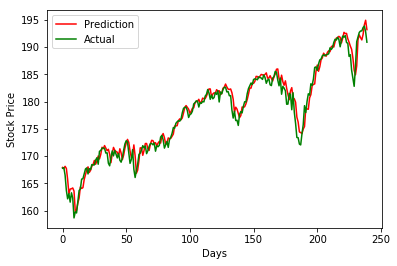

In [30]:
plt.figure()
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.plot(test_predictions*denorm_const, 'r', label='Prediction')
plt.plot(test_labels[0]*denorm_const, 'g', label='Actual')
plt.legend()
plt.show()